In [1]:
from strikepoint.driver import LeptonDriver
from strikepoint.producer import FrameProducer
from strikepoint.frames import FrameInfo, FrameInfoReader
from IPython.display import Image, display
from picamera2 import Picamera2
import numpy as np

import cv2
import numpy as np



In [2]:
def showFrame(frame):
    ok, buf = cv2.imencode('.png', frame)
    if not ok:
        raise RuntimeError("Could not encode frame to PNG")
    display(Image(data=buf.tobytes()))


[4:37:18.819817396] [5632]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[4:37:18.828970293] [5647]  INFO RPI pisp.cpp:720 libpisp version 1.3.0
[4:37:18.831465913] [5647]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/pisp/imx708.json
[4:37:18.838585251] [5647]  INFO Camera camera_manager.cpp:220 Adding camera '/base/axi/pcie@1000120000/rp1/i2c@88000/imx708@1a' for pipeline handler rpi/pisp
[4:37:18.838600269] [5647]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@88000/imx708@1a to CFE device /dev/media1 and ISP device /dev/media2 using PiSP variant BCM2712_D0


2025-12-17 21:05:28 [INFO] driver.c:269 - LEPTON Driver Starting Up...
2025-12-17 21:05:28 [INFO] driver.c:276 - Configuring /def/spidev0.0: mode=3, bitsPerWord=8, speed=10000000 Hz
2025-12-17 21:05:28 [INFO] driver.c:295 - Configuring camera port
2025-12-17 21:05:29 [INFO] driver.c:325 - STARTUP Camera Serial Number: 22395375
2025-12-17 21:05:29 [INFO] driver.c:329 - STARTUP Camera Uptime: 533966 seconds
2025-12-17 21:05:29 [INFO] driver.c:333 - STARTUP aux temperature: 91.58 F
2025-12-17 21:05:29 [INFO] driver.c:337 - STARTUP FPA Temperature: 92.53 F
2025-12-17 21:05:29 [INFO] driver.c:341 - STARTUP Radiometry enabled: 1
2025-12-17 21:05:29 [INFO] driver.c:345 - STARTUP AGC enabled: 0
2025-12-17 21:05:29 [INFO] driver.c:348 - STARTUP Camera status: 4


[4:37:19.982235166] [5632]  INFO Camera camera.cpp:1215 configuring streams: (0) 640x480-XBGR8888/sRGB (1) 1536x864-BGGR_PISP_COMP1/RAW
[4:37:19.982339482] [5647]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@88000/imx708@1a - Selected sensor format: 1536x864-SBGGR10_1X10/RAW - Selected CFE format: 1536x864-PC1B/RAW


FrameProducer loop took too long: 0.264s
Min thermal value: 67.20799255371094
Max thermal value: 78.02601623535156


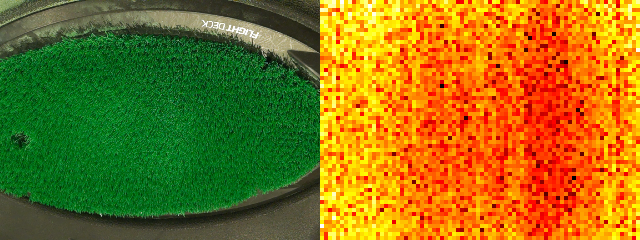

In [3]:

with Picamera2() as picam:
    with LeptonDriver() as driver:
        picam.start()
        driver.setLogFile('logsFromDevNotebook.log')
        driver.startPolling()
        # TODO: Use Picamera2 to set up the camera properly
        # picam2 = Picamera2()
        producer = FrameProducer(driver, picam)
        frameInfo = producer.getFrameInfo()
        thermRaw = frameInfo.rawFrames['thermal']
        print(f"Min thermal value: {float(np.min(thermRaw))}")
        print(f"Max thermal value: {float(np.max(thermRaw))}")

        frame = np.hstack((frameInfo.rgbFrames['visual'], 
                            frameInfo.rgbFrames['thermal']))
        showFrame(frame)
        # # this is bad, need something to synchronize here
        # showFrame(producer.lastThermalRaw)
        # showFrame(producer.lastThermalDiff)
        # showFrame(producer.lastVisualRaw)
        producer.stop()

In [4]:
%load_ext autoreload
%autoreload 2

Frame #0
Min thermal value: 93.32601165771484
Max thermal value: 94.62201690673828
Frame #10
Min thermal value: 93.30799865722656
Max thermal value: 94.58598327636719
Frame #20
Min thermal value: 93.23597717285156
Max thermal value: 94.47798156738281
Frame #30
Min thermal value: 93.23597717285156
Max thermal value: 94.38800811767578
Frame #40
Min thermal value: 93.43400573730469
Max thermal value: 127.31002044677734
Frame #50
Min thermal value: 93.43400573730469
Max thermal value: 129.4340057373047
Frame #60
Min thermal value: 93.68598175048828
Max thermal value: 130.17201232910156


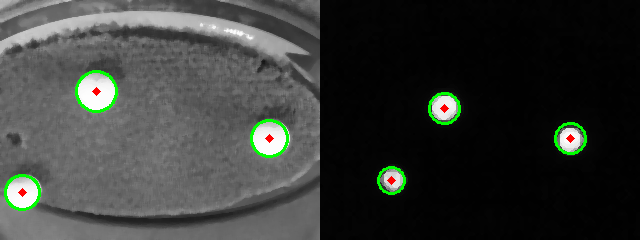

Frame #70
Min thermal value: 93.75799560546875
Max thermal value: 130.15399169921875


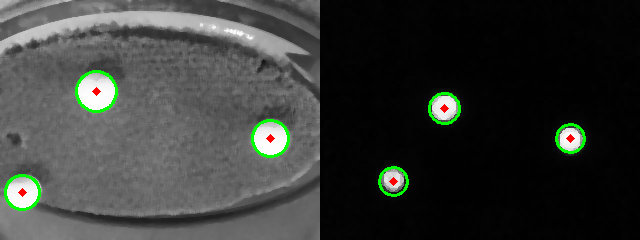

Frame #80
Min thermal value: 94.28001403808594
Max thermal value: 130.531982421875


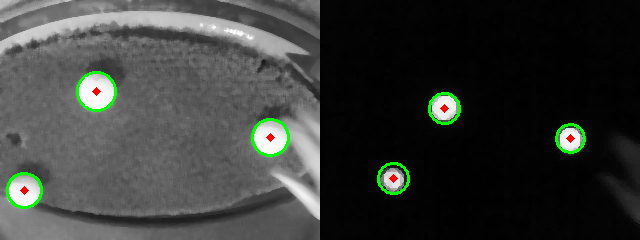

Frame #90
Min thermal value: 94.80197143554688
Max thermal value: 130.4779815673828
Frame #100
Min thermal value: 94.91001892089844
Max thermal value: 130.2979736328125


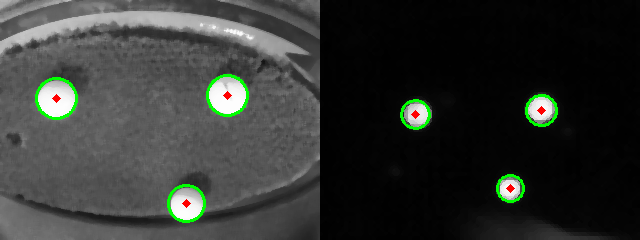

Frame #110
Min thermal value: 94.94599914550781
Max thermal value: 129.70399475097656
Frame #120
Min thermal value: 95.07201385498047
Max thermal value: 129.614013671875


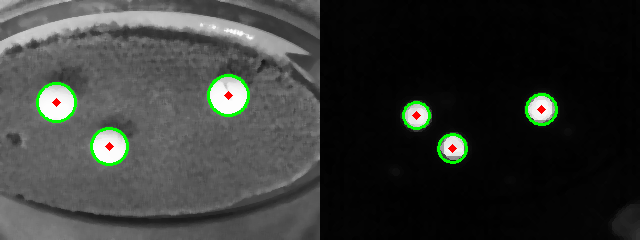

Frame #130
Min thermal value: 95.03598022460938
Max thermal value: 128.4979705810547
Frame #140
Min thermal value: 94.7659912109375
Max thermal value: 128.40798950195312
Frame #150
Min thermal value: 94.7659912109375
Max thermal value: 128.17398071289062


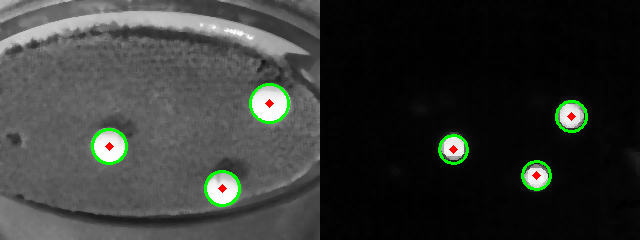

Frame #160
Min thermal value: 95.10799407958984
Max thermal value: 127.81401824951172
Frame #170
Min thermal value: 94.83800506591797
Max thermal value: 127.8680191040039


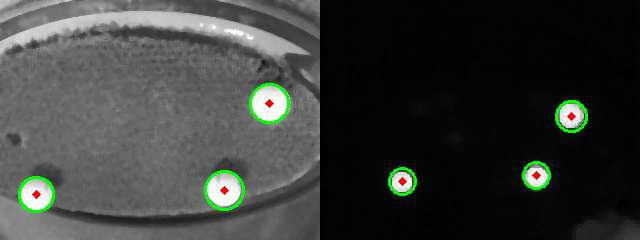

Frame #180
Min thermal value: 95.07201385498047
Max thermal value: 127.76002502441406
Frame #190
Min thermal value: 94.73001098632812
Max thermal value: 127.59797668457031


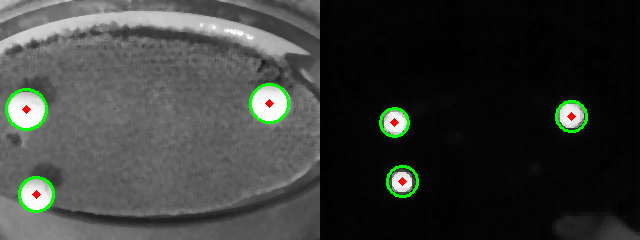

Frame #200
Min thermal value: 94.62201690673828
Max thermal value: 127.45399475097656


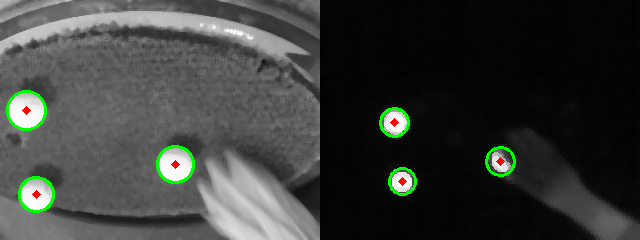

Frame #210
Min thermal value: 94.65799713134766
Max thermal value: 127.07601165771484
Frame #220
Min thermal value: 94.62201690673828
Max thermal value: 125.33000946044922
Frame #230
Min thermal value: 94.42398834228516
Max thermal value: 127.4000015258789


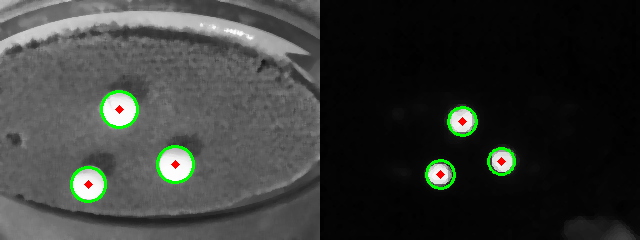

Frame #240
Min thermal value: 94.20799255371094
Max thermal value: 127.31002044677734


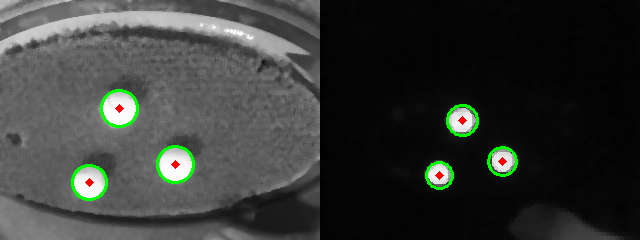

Frame #250
Min thermal value: 94.42398834228516
Max thermal value: 127.25602722167969


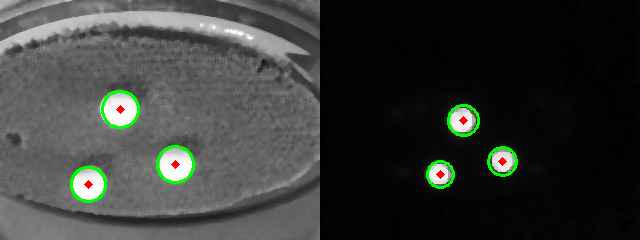

Frame #260
Min thermal value: 94.17201232910156
Max thermal value: 126.94999694824219


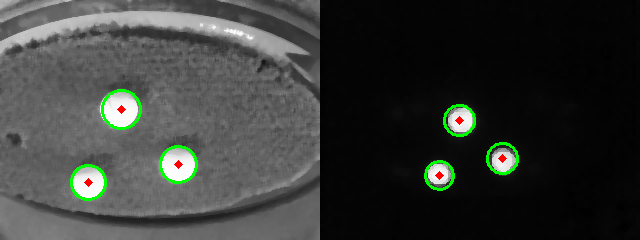

Frame #270
Min thermal value: 93.99200439453125
Max thermal value: 126.60799407958984


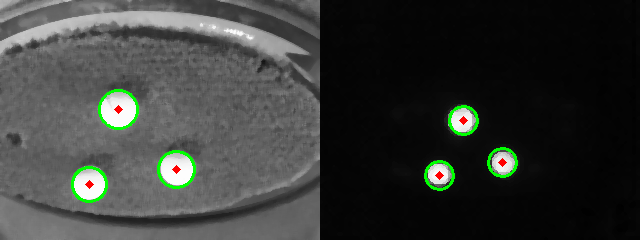

Frame #280
Min thermal value: 93.99200439453125
Max thermal value: 126.15799713134766


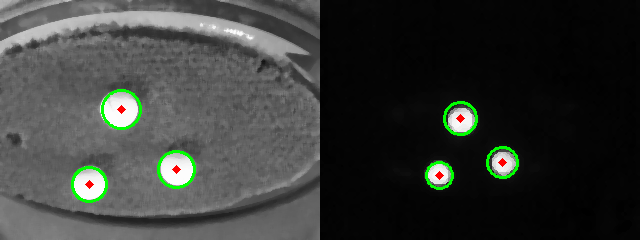

Frame #290
Min thermal value: 93.8840103149414
Max thermal value: 125.97798156738281


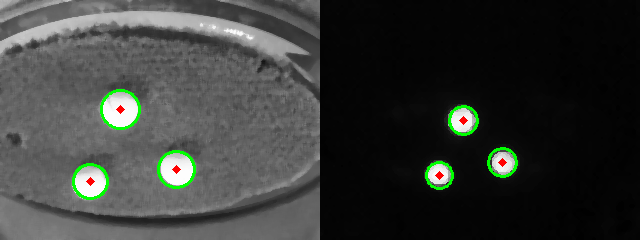

In [5]:
with FrameInfoReader("demo-three-balls.bin") as reader:
    frameInfoList = list(enumerate(reader.readAllFrameInfo()))
    # (visFrameBase, thermFrameBase, _) = np.hsplit(frameList[0][1], 3)
    # visFrameBase = cv2.cvtColor(visFrameBase, cv2.COLOR_BGR2GRAY)

    for i, frameInfo in frameInfoList[::10]:
        visFrame = frameInfo.rgbFrames['visual']
        thermFrame = frameInfo.rgbFrames['thermal']
        print(f"Frame #{i}")
        # showFrame(np.hstack((visFrame, thermFrame)))
        thermalRaw = frameInfo.rawFrames['thermal']
        print(f"Min thermal value: {float(np.min(thermalRaw))}")
        print(f"Max thermal value: {float(np.max(thermalRaw))}")
        # showFrame(thermFrame)
        # visCircles = findTargetCircleCount(visFrame, 1, startRadius=10)
        try:
            # showFrame(thermFrame)
            visDemo, visCircles = \
                FrameProducer.findTargetCircleCount(visFrame, 3)
            thermDemo, thermCircles = \
                FrameProducer.findTargetCircleCount(thermFrame, 3)
            showFrame(np.hstack((visDemo, thermDemo)))
        except RuntimeError as ex:
            # print(f"NOT Frame #{i}")
            continue

In [7]:
from strikepoint.frames import FrameInfoReader
import numpy as np


with FrameInfoReader("demo-three-hits.bin") as reader:
    frameInfoList = list(enumerate(reader.readAllFrameInfo()))

    for i, frameInfo in frameInfoList[245:250:]:
        print(f"Frame #{i}")
        visFrame = frameInfo.rgbFrames['visual']
        thermFrame = frameInfo.rgbFrames['thermal']

        visFrame = frameInfo.rgbFrames['visual']
        thermFrame = frameInfo.rgbFrames['thermal']

        # if frameInfo.metadata.get('hasBall', True):
        #     visDemo, visCircles = \
        #         FrameProducer.findTargetCircleCount(visFrame, 1)
        # else:
        #     showFrame(np.hstack((visFrame, thermFrame)))



        # ballPattern = tuple(f[1].metadata.get('hasBall', False) 
        #                for f in frameInfoList[i-3:i+1])
        # if ballPattern == (True, True, False, False):
        #     for f in frameInfoList[i-3:i+1]:
        #         visFrame = f[1].rgbFrames['visual']
        #         thermFrame = f[1].rgbFrames['thermal']
        #         showFrame(np.hstack((visFrame, thermFrame)))
            # visCircles = findTargetCircleCount(visFrame, 1, startRadius=10)
            # try:
            #     # showFrame(thermFrame)
            #     visDemo, visCircles = \
            #         FrameProducer.findTargetCircleCount(visFrame, 1)
            #     showFrame(visDemo)
            # except RuntimeError as ex:
            #     # print(f"NOT Frame #{i}")
            #     continue

Frame #245
Frame #246
Frame #247
Frame #248
Frame #249
